<a href="https://colab.research.google.com/github/FutureAndroidLearn/coursera-kaggle-project/blob/master/04_Modelling_lag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Check versions**

In [21]:
import numpy as np
import pandas as pd 
import sklearn
import seaborn as sns

for p in [np, pd, sklearn, sns]:
    print (p.__name__, p.__version__)

numpy 1.18.4
pandas 1.0.4
sklearn 0.22.2.post1
seaborn 0.10.1


The following code has been tested in:

*   numpy 1.18.4
*   pandas 1.0.4
*   sklearn 0.22.2.post1
*   seaborn 0.10.1







# **Summary**

In this final project a model has been created in order to predict future sales at 1C Company, one of the largest software firms. The final model was built on a ensembling between XGBoost and a Linear Regression models. The most important features in order to predict future sales were: XXXXXXXXX



In [0]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook
import gc
import matplotlib.pyplot as plt
%matplotlib inline 
from itertools import product
import time

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# **EDA**


The data provided includes:

## File descriptions

- **sales_train.csv**: Train set. Daily historical data from January 2013 to October 2015
- **test.csv**: Test set. You need forecast the sales for these shops and products for November 2015
- **sample_submission.csv**: A sample submission in the correct format
- **items.csv**: Supplemental information about the items/products
- **items_categories.csv**: supplemental information about the items categories
- **shops.csv**: supplemental information about the shops

## Data fields

- **ID**:An id that represents a (Shop, Item) tuple within the test set
- **shop_id**: Unique identifier of a shop
- **item_id**: Unique identifier of a product
- **item_category_id**: Unique identifier of a item category
- **item_cnt_day**: Number of products sold. Your are predicting a monthly amount of this measure
- **item_price**: Current price of a item
- **date**: date in format dd/mm/yyyy
- **date_block_num**: A consecutive month number, used for convinience. January 2013 is 0, February 2013 is 1 ... October 2015 is 33
- **item_name**: Name of item
- **shop_name**: Name of shop
- **item_category_name**: Name of category name

In [0]:
# Import data from csv files
sales_data = pd.read_csv('/content/drive/My Drive/coursera-kaggle-project/sales_train.zip')
shops_data = pd.read_csv('/content/drive/My Drive/coursera-kaggle-project/shops.csv')
categories_data = pd.read_csv('/content/drive/My Drive/coursera-kaggle-project/item_categories.csv')
items_data = pd.read_csv('/content/drive/My Drive/coursera-kaggle-project/items.csv')
test_data = pd.read_csv('/content/drive/My Drive/coursera-kaggle-project/test.csv').set_index('ID')

In [14]:
sales_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [15]:
# Sum sales per day.
df = sales_data.copy()
total_per_day = df.groupby('date').sum().sort_values(by=['item_cnt_day'], ascending = False).reset_index()
total_per_day.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,28.12.2013,103774,315275,93436151,9.491239e+06,13343.0
1,30.12.2014,214452,309775,94418782,1.220957e+07,13236.0
2,29.12.2013,102685,315291,92980641,9.184175e+06,12863.0
3,30.12.2013,100518,302621,89671936,9.448912e+06,12823.0
4,31.12.2014,191981,275199,83384841,1.127468e+07,11394.0


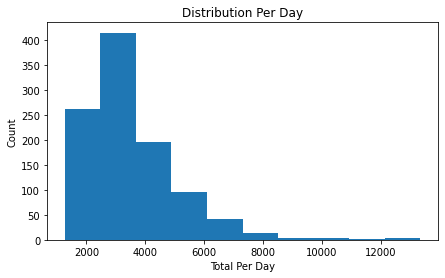

In [16]:
fig, ax = plt.subplots(figsize=(7,4))
plt.hist(total_per_day.item_cnt_day)
ax.set (xlabel = "Total Per Day",
        ylabel = "Count",
        title = "Distribution Per Day")
plt.show()

Most of dayly sales are around 2000 and 4000 items

In [17]:
# Sum sales per month
total_per_month = df.groupby('date_block_num').sum().sort_values(by=['item_cnt_day'], ascending = False).reset_index()
total_per_month.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,11,4747485,1424369716,1.431799e+08,183342.0
1,23,4339498,1330492992,1.794057e+08,168755.0
2,2,4016457,1220911622,8.429831e+07,147142.0
3,8,3208314,957871641,7.270157e+07,133332.0
4,0,3417068,1183971787,8.221187e+07,131479.0


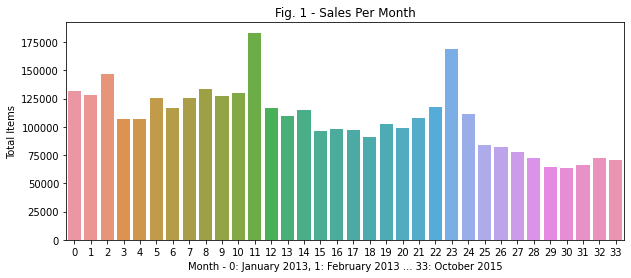

Max:183342.0
Min:63187.0
Mean:107300.17647058824


In [25]:
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(total_per_month.date_block_num, total_per_month.item_cnt_day)
ax.set (xlabel = "Month - 0: January 2013, 1: February 2013 ... 33: October 2015",
        ylabel = "Total Items",
        title = "Fig. 1 - Sales Per Month")
plt.show()
print("Max:{}".format(total_per_month.item_cnt_day.max()))
print("Min:{}".format(total_per_month.item_cnt_day.min()))
print("Mean:{}".format(total_per_month.item_cnt_day.mean()))

It can be seen that December are the months with higher sales (month 11 and 13). Also is observed that there is a trend of progressive decrease in sales year after year.

Test set is made up of (shop, item) pairs so we should explorer how is the behaviour of sales respect to the shops.

In [23]:
# Sum sales per shop
total_per_shop = df.groupby('shop_id').sum().sort_values(by=['item_cnt_day'], ascending = False).reset_index()
total_per_shop.head()

,shop_id,date_block_num,item_id,item_price,item_cnt_day
0,31,3519304,2613938432,1.707634e+08,310777.0
1,25,2803911,2017578669,1.555576e+08,241920.0
2,54,1700597,1575568395,1.096694e+08,185790.0
3,28,2106668,1503076500,1.252947e+08,184557.0
4,42,1762898,1149534465,1.015515e+08,144934.0


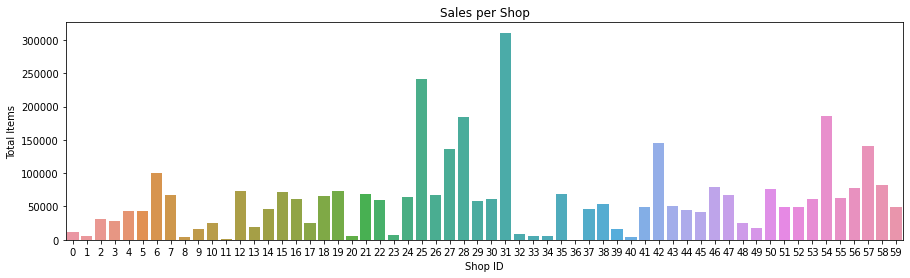

In [24]:
fig, ax = plt.subplots(figsize=(15,4))
sns.barplot(total_per_shop.shop_id, total_per_shop.item_cnt_day)
ax.set (xlabel = "Shop ID",
        ylabel = "Total Items",
        title = "Sales per Shop")
plt.show()

Next, it is investigate if the individual behaviour of shops over time is similar to the one observed in Fig 1. At first place, are considered the shops with less sales (i.e: shop ID 8, 40)

In [26]:
df1 = df[df['shop_id'] == 8]
total_shop_low1 = df1.groupby('date_block_num').sum().sort_values(by=['item_cnt_day'], ascending = False).reset_index()
total_shop_low1

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,11112,13864194,902495.500,1463.0
1,1,8736,11074599,721811.395,1156.0
2,2,7440,9308031,601366.810,977.0
3,3,8,4809,599.000,-1.0


There is somenthing that seems interesting. This shop was open 4 months only. This is a situation that can be found in others shops.

In [27]:
# A new feature is added to the shops_data dataframe, to identify how many months the shop was open.

shops_data_ft1 = shops_data.copy()
months_open = [len(df[df['shop_id']==x].groupby(['date_block_num']).sum()) for x in shops_data_ft1.shop_id]
shops_data_ft1['months_open'] = months_open
shops_data_ft1.head()

,shop_name,shop_id,months_open
0,"!Якутск Орджоникидзе, 56 фран",0,2
1,"!Якутск ТЦ ""Центральный"" фран",1,2
2,"Адыгея ТЦ ""Мега""",2,34
3,"Балашиха ТРК ""Октябрь-Киномир""",3,34
4,"Волжский ТЦ ""Волга Молл""",4,34


In [28]:
len(shops_data_ft1[shops_data_ft1['months_open'] == 34])

32

Out of 60 shops, only 32 remained open for all the 34 months. But is also possible, that some new shops were opened in the last months, and remain open in the month 34. 

In [29]:
# This fetaure let us know if the shop was open in the last month of the time serie

shops_data_ft2 = shops_data_ft1
df_tempo = df[df['date_block_num'] == 33]
last_month_open = np.sort(df_tempo['shop_id'].unique())
last_month_open = [x in last_month_open for x in shops_data_ft2.shop_id]
shops_data_ft2['last_month_open'] = last_month_open
shops_data_ft2.head()

,shop_name,shop_id,months_open,last_month_open
0,"!Якутск Орджоникидзе, 56 фран",0,2,False
1,"!Якутск ТЦ ""Центральный"" фран",1,2,False
2,"Адыгея ТЦ ""Мега""",2,34,True
3,"Балашиха ТРК ""Октябрь-Киномир""",3,34,True
4,"Волжский ТЦ ""Волга Молл""",4,34,True


# **Data Leakages**

Now, it is reviewed if the ***test set*** includes all the shops

In [30]:
len(test_data.shop_id.unique())


42

It is clear that some shops has been excluded from test data.

In [31]:
shops_data_tempo = shops_data_ft2
is_test = [x in test_data.shop_id.unique() for x in shops_data_tempo.shop_id]
shops_data_tempo['is_test'] = is_test

shops_data_tempo

,shop_name,shop_id,months_open,last_month_open,is_test
0,"!Якутск Орджоникидзе, 56 фран",0,2,False,False
1,"!Якутск ТЦ ""Центральный"" фран",1,2,False,False
2,"Адыгея ТЦ ""Мега""",2,34,True,True
3,"Балашиха ТРК ""Октябрь-Киномир""",3,34,True,True
4,"Волжский ТЦ ""Волга Молл""",4,34,True,True
5,"Вологда ТРЦ ""Мармелад""",5,33,True,True
6,"Воронеж (Плехановская, 13)",6,34,True,True
7,"Воронеж ТРЦ ""Максимир""",7,34,True,True
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,4,False,False
9,Выездная Торговля,9,4,True,False


Acording to this, in the ***test set*** only are included the shops that are open at 34th month. The only exceptions are shops 9 y 20.

In [33]:
df_tempo = df[df['shop_id'] == 9]
total_shop_tempo = df_tempo.groupby('date_block_num').sum().sort_values(by=['date_block_num'], ascending = True).reset_index()
total_shop_tempo

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,9,13392,17668038,1.617737e+06,6526.0
1,21,12753,18231529,1.839812e+06,6155.0
2,27,9,5672,3.190000e+03,-1.0
3,33,7605,13386757,1.253564e+06,3186.0


In [34]:
df_tempo = df[df['shop_id'] == 20]
total_shop_tempo = df_tempo.groupby('date_block_num').sum().sort_values(by=['date_block_num'], ascending = True).reset_index()
total_shop_tempo

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,21,18900,16550232,1.150218e+06,3261.0
1,33,16940,13563669,1.239048e+06,2611.0


Those two shops, looks like it just has been re-opened in the month 33. Therefore, the information that those two shops deliver seems not to be meaningful. 

Now, it is reviewed if the ***test set*** includes all the items that are included in the ***training set***

In [42]:
print('Items in training set %i' % len(sales_data.item_id.unique()))
print('Items in test set %i' % len(test_data.item_id.unique()))


Items in training set 21807
Items in test set 5100


This information about the test set, will be used in feature engineering. 

# **Feature Engineering**

In [0]:
## Initial Feature Matrix

# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales_data['date_block_num'].unique():
    cur_shops = sales_data.loc[sales_data['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales_data.loc[sales_data['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = df.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum'})

gb.rename({'item_cnt_day':'target'}, axis = 1, inplace =True)
all_data = pd.merge(grid, gb, how='left', on=index_cols)

all_data['target'] = (all_data['target']
                            .fillna(0)
                            .clip(0,20))

## Integrate test data with train data

test_data['date_block_num'] = 34
all_data = pd.concat([all_data, test_data], ignore_index=True, sort=False, keys=index_cols)
all_data.fillna(0, inplace=True) # 34 month

In [0]:
## Other Features

# Same as above but with shop-month aggregates
gb = sales_data.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
gb.rename({'item_cnt_day':'target_shop'}, axis = 1, inplace =True)
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales_data.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
gb.rename({'item_cnt_day':'target_item'}, axis = 1, inplace =True)
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

# List of columns that we will use to create lags
# target, traget_item, taget_shop
cols_to_rename = list(all_data.columns.difference(index_cols))

In [69]:
## Time lag features

shift_range = [1, 2, 3, 4, 5, 6]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items_data[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)

gc.collect();

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [74]:
# Features from data leakage

test_items = test_data.item_id.unique()
item_in_test = [x in test_items for x in all_data.item_id]
all_data['item_in_test'] = item_in_test

test_shops = test_data.shop_id.unique()
shop_in_test = [x in test_shops for x in all_data.shop_id]
all_data['shop_in_test'] = shop_in_test

all_data['item_in_test'] = all_data['item_in_test'].astype(np.integer)
all_data['shop_in_test'] = all_data['shop_in_test'].astype(np.integer)
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_6,target_item_lag_6,target_shop_lag_6,item_category_id,item_in_test,shop_in_test
0,59,22154,0,1.0,2017.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,1,1
1,59,2552,0,0.0,2017.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58,0,1
2,59,2554,0,0.0,2017.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58,0,1
3,59,2555,0,0.0,2017.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,0,1
4,59,2564,0,0.0,2017.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59,0,1


#**Validation**

In [0]:
dates = all_data['date_block_num']

last_block = dates.max()

dates_train = dates[dates <  last_block-1]
dates_val  = dates[dates == last_block-1]
dates_test  = dates[dates == last_block]

X_train = all_data.loc[dates <  last_block-1].drop(to_drop_cols, axis=1)
X_val =  all_data.loc[dates == last_block-1].drop(to_drop_cols, axis=1)
X_test = all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block-1, 'target'].values
y_val =  all_data.loc[dates == last_block-1, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

In [0]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=50,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 5)

time.time() - ts

In [0]:
# Conditions 
df = sales_data[sales_data['date_block_num'] > 5]  # Max lag 6 months, first 6 months are not considered
items_up = sales_data[sales_data['date_block_num']>=28].item_id.unique() # Use products solds in the last 5 months
df = df[df['item_id'].isin(items_up)] 

In [0]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,months_open
483231,22.07.2013,6,28,51,249.0,1.0,34
483232,27.07.2013,6,28,51,249.0,1.0,34
483233,28.07.2013,6,28,59,249.0,1.0,34
483234,01.07.2013,6,28,53,299.0,1.0,34
483235,25.07.2013,6,28,45,299.0,1.0,34


In [0]:
## Initial Feature Matrix

# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in df['date_block_num'].unique():
    cur_shops = df.loc[df['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = df.loc[df['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = df.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum'})

gb.rename({'item_cnt_day':'target'}, axis = 1, inplace =True)
all_data = pd.merge(grid, gb, how='left', on=index_cols)

all_data['target'] = (all_data['target']
                            .fillna(0)
                            .clip(0,20))

## Integrate test data with train data

test_data['date_block_num'] = 34
all_data = pd.concat([all_data, test_data], ignore_index=True, sort=False, keys=index_cols)
all_data.fillna(0, inplace=True) # 34 month

In [0]:
all_data.tail()

,shop_id,item_id,date_block_num,target
4706615,45,18454,34,0.0
4706616,45,16188,34,0.0
4706617,45,15757,34,0.0
4706618,45,19648,34,0.0
4706619,45,969,34,0.0


In [0]:
## Other Features

# Same as above but with shop-month aggregates
gb = sales_data.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
gb.rename({'item_cnt_day':'target_shop'}, axis = 1, inplace =True)
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales_data.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
gb.rename({'item_cnt_day':'target_item'}, axis = 1, inplace =True)
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

# List of columns that we will use to create lags
#target, traget_item, taget_shop
cols_to_rename = list(all_data.columns.difference(index_cols))

In [0]:
all_data.tail()

,shop_id,item_id,date_block_num,target,target_shop,target_item
4706615,45,18454,34,0.0,0.0,0.0
4706616,45,16188,34,0.0,0.0,0.0
4706617,45,15757,34,0.0,0.0,0.0
4706618,45,19648,34,0.0,0.0,0.0
4706619,45,969,34,0.0,0.0,0.0


In [0]:
## Time lag features

shift_range = [1, 2, 3, 4, 5, 6]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items_data[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [0]:
all_data.tail()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_6,target_item_lag_6,target_shop_lag_6,item_category_id
4706615,45,18454,34,0.0,0.0,0.0,1.0,2.0,702.0,0.0,1.0,654.0,0.0,3.0,710.0,0.0,11.0,675.0,0.0,18.0,622.0,0.0,24.0,762.0,55
4706616,45,16188,34,0.0,0.0,0.0,0.0,1.0,702.0,0.0,3.0,654.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64
4706617,45,15757,34,0.0,0.0,0.0,0.0,5.0,702.0,0.0,3.0,654.0,0.0,4.0,710.0,0.0,4.0,675.0,0.0,8.0,622.0,0.0,10.0,762.0,55
4706618,45,19648,34,0.0,0.0,0.0,0.0,2.0,702.0,0.0,3.0,654.0,0.0,6.0,710.0,0.0,2.0,675.0,0.0,4.0,622.0,0.0,4.0,762.0,40
4706619,45,969,34,0.0,0.0,0.0,0.0,3.0,702.0,0.0,5.0,654.0,0.0,1.0,710.0,0.0,2.0,675.0,0.0,1.0,622.0,0.0,2.0,762.0,37


In [0]:
dates = all_data['date_block_num']

last_block = dates.max()

dates_train = dates[dates <  last_block-1]
dates_val  = dates[dates == last_block-1]
dates_test  = dates[dates == last_block]

X_train = all_data.loc[dates <  last_block-1].drop(to_drop_cols, axis=1)
X_val =  all_data.loc[dates == last_block-1].drop(to_drop_cols, axis=1)
X_test = all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block-1, 'target'].values
y_val =  all_data.loc[dates == last_block-1, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

In [0]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=50,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 5)

time.time() - ts

[22:41:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:41:45] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.33892	validation_1-rmse:1.0621
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1.29378	validation_1-rmse:1.02717
[2]	validation_0-rmse:1.25754	validation_1-rmse:0.997743
[3]	validation_0-rmse:1.22063	validation_1-rmse:0.973777
[4]	validation_0-rmse:1.18927	validation_1-rmse:0.953998
[5]	validation_0-rmse:1.16353	validation_1-rmse:0.934426
[6]	validation_0-rmse:1.14321	validation_1-rmse:0.919648
[7]	validation_0-rmse:1.12442	validation_1-rmse:0.906617
[8]	validation_0-rmse:1.11084	validation_1-rmse:

1138.824010848999

In [0]:
pred_xgb = model.predict(X_val)

rmse_cl = np.sqrt(mean_squared_error(y_val, pred_xgb))
print(rmse_cl)

0.8416248


In [0]:
y_test = model.predict(X_test)

submission = pd.DataFrame({
    "ID": test_data.index, 
    "item_cnt_month": y_test
})
submission.to_csv('/content/drive/My Drive/coursera-kaggle-project/xgb_submission.csv', index=False)